In [1]:
!kaggle datasets download -d khan1803115/eeg-dataset-for-emotion-recognition
!mkdir -p datasets/khan1803115
!unzip eeg-dataset-for-emotion-recognition.zip -d datasets/khan1803115/
!rm eeg-dataset-for-emotion-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/khan1803115/eeg-dataset-for-emotion-recognition
License(s): Apache 2.0
100% 181M/181M [00:02<00:00, 112MB/s] 
100% 181M/181M [00:02<00:00, 90.5MB/s]
Archive:  eeg-dataset-for-emotion-recognition.zip
  inflating: datasets/khan1803115/Data/S01G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G4AllChannels.csv  
  inflating:

In [2]:
import os

import numpy as np
import pandas as pd
!pip install mne
import mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.0 MB/s eta 0:00:00


In [3]:
import joblib
# from google.colab import files

def save_artifact(artifact,name):
  joblib.dump(artifact,name)
  # files.download(name)


## Data Loading

In [4]:
khan_dataset_dir = "datasets/khan1803115/"
valence = pd.read_csv(khan_dataset_dir+"valence_normalize.csv")
arousal = pd.read_csv(khan_dataset_dir+"arousal_normalize.csv")
data = [pd.read_csv(khan_dataset_dir+"Data/"+file) for file in os.listdir(khan_dataset_dir+"Data/")]

channels = data[0].columns[:-2]
label_columns = data[0].columns[-2:]
fs = 128

In [5]:
eeg_data = np.array([data_[channels][:38000] for data_ in data])
valence_arousal_values = np.array([data_[label_columns].mean() for data_ in data])
eeg_data.shape, valence_arousal_values.shape

((100, 38000, 14), (100, 2))

In [6]:
def map_labels(valence, arousal):
    if valence <= 2.5 and arousal <= 2.5:
        return 0  # Low valence, low arousal
    elif valence <= 2.5 and arousal > 2.5:
        return 1  # Low valence, high arousal
    elif valence > 2.5 and arousal <= 2.5:
        return 2  # High valence, low arousal
    else:
        return 3  # High valence, high arousal

# Example usage:
# labels_mapped = np.array([map_labels(valence, arousal) for valence, arousal in valence_arousal_values])
# labels_mapped

In [7]:
# Make use of 1280 samples for an epoch with 0 samples overlapping between succesive epochs
epoch_starting_points = np.arange(0,38252,1280-0)[:-4]

eeg_epochs = []

for i in range(len(data)):
    epochs = []
    for epoch_starting_point in epoch_starting_points:
        epochs.append(eeg_data[i,epoch_starting_point:epoch_starting_point+1280,:])

    eeg_epochs.append(epochs)

eeg_epochs = np.array(eeg_epochs)

eeg_epochs.shape

(100, 26, 1280, 14)

In [8]:
epoch_targets = []

for i in range(len(data)):
  targets = [valence_arousal_values[i]]*26
  epoch_targets.append(targets)

epoch_targets = np.array(epoch_targets)

epoch_targets.shape

(100, 26, 2)

In [9]:
eeg_epochs = eeg_epochs.reshape(2600,1280,14)
epoch_targets = epoch_targets.reshape(2600,2)
epoch_targets = np.array([map_labels(valence, arousal) for valence, arousal in epoch_targets])
epoch_targets = np.expand_dims(epoch_targets, axis=1)

eeg_epochs.shape, epoch_targets.shape

((2600, 1280, 14), (2600, 1))

## Preprocessing

In [10]:
lowcut = 1
highcut = 45

filtered_eeg_epochs = np.empty((2600,1280,14))

for e,epoch in enumerate(eeg_epochs):
  filtered = mne.filter.filter_data(epoch.T,fs,lowcut,highcut,verbose=0)
  filtered_eeg_epochs[e,:,:] = filtered.T

filtered_eeg_epochs.shape

(2600, 1280, 14)

## Make Dataloader

In [11]:
import random

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

# Set the device
device_ = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device: {device_}")

Current Device: cpu


In [12]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

  def __init__(self, features, targets, transform=None, device__="cpu"):
    self.features = torch.tensor(features,device=device__)
    self.targets = torch.tensor(targets,device=device__)
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    feature = self.features[idx,::]
    target = self.targets[idx]
    if self.transform:
      feature = self.transform(feature)
    return feature, target

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

random.seed(120)
torch.manual_seed(120)

emotion_encoder = OneHotEncoder(sparse=False)

X, y = filtered_eeg_epochs, emotion_encoder.fit_transform(epoch_targets)

# feature_scaler = MinMaxScaler()
# y = feature_scaler.fit_transform(y)


X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.20, random_state=100)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=100)

for i in range(len(X_train)):
  scaler = StandardScaler()
  X_train[i,::] = scaler.fit_transform(X_train[i,::])

for i in range(len(X_test)):
  # scaler = StandardScaler()
  X_test[i,::] = scaler.transform(X_test[i,::])

for i in range(len(X_val)):
  # scaler = StandardScaler()
  X_val[i,::] = scaler.transform(X_val[i,::])

# feature_scaler = MinMaxScaler()
# y_train = feature_scaler.fit_transform(y_train)
# y_test = feature_scaler.transform(y_test)
# y_val = feature_scaler.transform(y_val)

print(f" Train Size :({X_train.shape}, {y_train.shape}) | Test Size : ({X_test.shape}, {y_test.shape}) | Validation Size: ({X_val.shape}, {y_val.shape})")

train_batch_size = 204
shuffle_ = True
num_workers_ = 5

# Make Train Dataloader
train_dataset = CustomDataset(X_train.astype(float),y_train.astype(float))
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=shuffle_, num_workers=num_workers_)

# Make Validation Dataloader
val_batch_size = 34
val_dataset = CustomDataset(X_val.astype(float),y_val.astype(float))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=shuffle_, num_workers=num_workers_)

X_train = torch.tensor(X_train).to(torch.float)
y_train = torch.tensor(y_train).to(torch.float)
X_train = X_train.to(device_)
y_train = y_train.to(device_)

X_test = torch.tensor(X_test).to(torch.float)
y_test = torch.tensor(y_test).to(torch.float)
X_test = X_test.to(device_)
y_test = y_test.to(device_)

X_val = torch.tensor(X_val).to(torch.float)
y_val = torch.tensor(y_val).to(torch.float)
X_val = X_val.to(device_)
y_val = y_val.to(device_)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


 Train Size :((2080, 1280, 14), (2080, 4)) | Test Size : ((260, 1280, 14), (260, 4)) | Validation Size: ((260, 1280, 14), (260, 4))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Modelling

In [15]:
class cnn_emotion_predictor(nn.Module):

  def __init__(self):
    super(cnn_emotion_predictor,self).__init__()

    self.conv = nn.Sequential(
      nn.Dropout(0.1),
      nn.BatchNorm1d(14),
      nn.Conv1d(14,14,kernel_size=32,stride=2,padding=0), # OUTPUT: C=14, L=609
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=2,stride=1), # OUTPUT: C=14, L=608
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
      nn.Conv1d(14,14,kernel_size=2,stride=2,padding=0), #OUTPUT: C=14, L=304
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=2,stride=1), # OUTPUT: C=14, L=303
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
      nn.Conv1d(14,14,kernel_size=3,stride=2,padding=0), #OUTPUT: C=14, L=151
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=4,stride=7), # OUTPUT: C=14, L=22
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
    )

    self.fc = nn.Sequential(
        # nn.Dropout(0.05),
        nn.Linear(14*22,98),
        nn.ReLU(),
        nn.BatchNorm1d(98),
        nn.Linear(98,50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,4),
        nn.Softmax()
    )

  def forward(self,x):
    x = torch.transpose(x,1,2)
    x = self.conv(x)
    x = x.view(x.size()[0],-1)
    x = self.fc(x)

    return x


class cnn(nn.Module):

  def __init__(self):
    super(cnn,self).__init__()

    self.conv = nn.Sequential(
      nn.Dropout(0.1),
      nn.BatchNorm1d(14),
      nn.Conv1d(14,14,kernel_size=32,stride=2,padding=0), # OUTPUT: C=14, L=609
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=2,stride=1), # OUTPUT: C=14, L=608
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
      nn.Conv1d(14,14,kernel_size=2,stride=2,padding=0), #OUTPUT: C=14, L=304
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=2,stride=1), # OUTPUT: C=14, L=303
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
      nn.Conv1d(14,14,kernel_size=3,stride=2,padding=0), #OUTPUT: C=14, L=151
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=4,stride=7), # OUTPUT: C=14, L=22
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
    )

    self.fc = nn.Sequential(
        # nn.Dropout(0.05),
        nn.Linear(14*22,98),
        nn.ReLU(),
        nn.BatchNorm1d(98),
        nn.Linear(98,50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,2),
        nn.ReLU()
    )

  def forward(self,x):
    x = torch.transpose(x,1,2)
    x = self.conv(x)
    x = x.view(x.size()[0],-1)
    x = self.fc(x)

    return x


In [16]:
regression_model = joblib.load("cnn_22.sav")
regression_model.keys()

dict_keys(['model', 'model_weights', 'performance'])

In [21]:
classification_model = cnn_emotion_predictor()

In [22]:
regModel_state_dict = regression_model["model"].state_dict()
clfModel_state_dict = classification_model.state_dict()

excluded_layers = ['fc.9.weight', 'fc.9.bias']

for name, param in regModel_state_dict.items():
    if name not in excluded_layers:
        clfModel_state_dict[name] = param

classification_model.load_state_dict(clfModel_state_dict)

<All keys matched successfully>

  0%|          | 1/200 [00:02<06:41,  2.02s/it]

----------------------------------------------------------------------------------
Epoch: 0/200 | loss: 1.45 |  validation loss: 1.48 | learning rate: [0.001]


  1%|          | 2/200 [00:03<06:31,  1.98s/it]

----------------------------------------------------------------------------------
Epoch: 1/200 | loss: 1.43 |  validation loss: 1.46 | learning rate: [0.001]


  2%|▏         | 3/200 [00:05<06:25,  1.95s/it]

----------------------------------------------------------------------------------
Epoch: 2/200 | loss: 1.41 |  validation loss: 1.42 | learning rate: [0.001]


  2%|▏         | 4/200 [00:07<06:20,  1.94s/it]

----------------------------------------------------------------------------------
Epoch: 3/200 | loss: 1.40 |  validation loss: 1.45 | learning rate: [0.001]


  2%|▎         | 5/200 [00:09<06:32,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 4/200 | loss: 1.39 |  validation loss: 1.42 | learning rate: [0.001]


  3%|▎         | 6/200 [00:13<08:37,  2.67s/it]

----------------------------------------------------------------------------------
Epoch: 5/200 | loss: 1.37 |  validation loss: 1.39 | learning rate: [0.001]


  4%|▎         | 7/200 [00:16<08:25,  2.62s/it]

----------------------------------------------------------------------------------
Epoch: 6/200 | loss: 1.37 |  validation loss: 1.43 | learning rate: [0.001]


  4%|▍         | 8/200 [00:18<08:16,  2.59s/it]

----------------------------------------------------------------------------------
Epoch: 7/200 | loss: 1.36 |  validation loss: 1.45 | learning rate: [0.001]


  4%|▍         | 9/200 [00:20<07:32,  2.37s/it]

----------------------------------------------------------------------------------
Epoch: 8/200 | loss: 1.35 |  validation loss: 1.41 | learning rate: [0.001]


  5%|▌         | 10/200 [00:22<07:13,  2.28s/it]

----------------------------------------------------------------------------------
Epoch: 9/200 | loss: 1.35 |  validation loss: 1.43 | learning rate: [0.001]


  6%|▌         | 11/200 [00:25<07:28,  2.37s/it]

----------------------------------------------------------------------------------
Epoch: 10/200 | loss: 1.32 |  validation loss: 1.40 | learning rate: [0.001]


  6%|▌         | 12/200 [00:27<07:32,  2.40s/it]

----------------------------------------------------------------------------------
Epoch: 11/200 | loss: 1.32 |  validation loss: 1.41 | learning rate: [0.0001]


  6%|▋         | 13/200 [00:29<07:01,  2.26s/it]

----------------------------------------------------------------------------------
Epoch: 12/200 | loss: 1.31 |  validation loss: 1.40 | learning rate: [0.0001]


  7%|▋         | 14/200 [00:31<06:36,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 13/200 | loss: 1.31 |  validation loss: 1.39 | learning rate: [0.0001]


  8%|▊         | 15/200 [00:33<06:24,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 14/200 | loss: 1.30 |  validation loss: 1.38 | learning rate: [0.0001]


  8%|▊         | 16/200 [00:35<06:14,  2.03s/it]

----------------------------------------------------------------------------------
Epoch: 15/200 | loss: 1.31 |  validation loss: 1.38 | learning rate: [0.0001]


  8%|▊         | 17/200 [00:37<06:23,  2.10s/it]

----------------------------------------------------------------------------------
Epoch: 16/200 | loss: 1.31 |  validation loss: 1.39 | learning rate: [0.0001]


  9%|▉         | 18/200 [00:40<07:02,  2.32s/it]

----------------------------------------------------------------------------------
Epoch: 17/200 | loss: 1.30 |  validation loss: 1.41 | learning rate: [0.0001]


 10%|▉         | 19/200 [00:42<06:37,  2.20s/it]

----------------------------------------------------------------------------------
Epoch: 18/200 | loss: 1.30 |  validation loss: 1.38 | learning rate: [0.0001]


 10%|█         | 20/200 [00:44<06:24,  2.14s/it]

----------------------------------------------------------------------------------
Epoch: 19/200 | loss: 1.30 |  validation loss: 1.38 | learning rate: [0.0001]


 10%|█         | 21/200 [00:46<06:08,  2.06s/it]

----------------------------------------------------------------------------------
Epoch: 20/200 | loss: 1.29 |  validation loss: 1.38 | learning rate: [0.0001]


 11%|█         | 22/200 [00:48<05:56,  2.00s/it]

----------------------------------------------------------------------------------
Epoch: 21/200 | loss: 1.29 |  validation loss: 1.34 | learning rate: [0.0001]


 12%|█▏        | 23/200 [00:50<05:45,  1.95s/it]

----------------------------------------------------------------------------------
Epoch: 22/200 | loss: 1.29 |  validation loss: 1.38 | learning rate: [0.0001]


 12%|█▏        | 24/200 [00:53<06:29,  2.22s/it]

----------------------------------------------------------------------------------
Epoch: 23/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [0.0001]


 12%|█▎        | 25/200 [00:55<06:26,  2.21s/it]

----------------------------------------------------------------------------------
Epoch: 24/200 | loss: 1.29 |  validation loss: 1.37 | learning rate: [0.0001]


 13%|█▎        | 26/200 [00:57<06:07,  2.11s/it]

----------------------------------------------------------------------------------
Epoch: 25/200 | loss: 1.28 |  validation loss: 1.41 | learning rate: [0.0001]


 14%|█▎        | 27/200 [00:59<05:55,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 26/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [0.0001]


 14%|█▍        | 28/200 [01:00<05:46,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 27/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1e-05]


 14%|█▍        | 29/200 [01:02<05:43,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 28/200 | loss: 1.27 |  validation loss: 1.40 | learning rate: [1e-05]


 15%|█▌        | 30/200 [01:05<06:00,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 29/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1e-05]


 16%|█▌        | 31/200 [01:07<06:20,  2.25s/it]

----------------------------------------------------------------------------------
Epoch: 30/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1e-05]


 16%|█▌        | 32/200 [01:09<06:01,  2.15s/it]

----------------------------------------------------------------------------------
Epoch: 31/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1e-05]


 16%|█▋        | 33/200 [01:11<05:47,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 32/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1e-05]


 17%|█▋        | 34/200 [01:13<05:36,  2.03s/it]

----------------------------------------------------------------------------------
Epoch: 33/200 | loss: 1.27 |  validation loss: 1.40 | learning rate: [1.0000000000000002e-06]


 18%|█▊        | 35/200 [01:15<05:31,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 34/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000002e-06]


 18%|█▊        | 36/200 [01:17<05:29,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 35/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000002e-06]


 18%|█▊        | 37/200 [01:20<06:13,  2.29s/it]

----------------------------------------------------------------------------------
Epoch: 36/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000002e-06]


 19%|█▉        | 38/200 [01:22<06:02,  2.23s/it]

----------------------------------------------------------------------------------
Epoch: 37/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000002e-06]


 20%|█▉        | 39/200 [01:24<05:41,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 38/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000002e-06]


 20%|██        | 40/200 [01:26<05:32,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 39/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000002e-07]


 20%|██        | 41/200 [01:28<05:21,  2.02s/it]

----------------------------------------------------------------------------------
Epoch: 40/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000002e-07]


 21%|██        | 42/200 [01:30<05:14,  1.99s/it]

----------------------------------------------------------------------------------
Epoch: 41/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000002e-07]


 22%|██▏       | 43/200 [01:33<05:51,  2.24s/it]

----------------------------------------------------------------------------------
Epoch: 42/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000002e-07]


 22%|██▏       | 44/200 [01:35<05:49,  2.24s/it]

----------------------------------------------------------------------------------
Epoch: 43/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000002e-07]


 22%|██▎       | 45/200 [01:37<05:28,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 44/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000002e-07]


 23%|██▎       | 46/200 [01:39<05:19,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 45/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 24%|██▎       | 47/200 [01:41<05:16,  2.07s/it]

----------------------------------------------------------------------------------
Epoch: 46/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 24%|██▍       | 48/200 [01:43<05:09,  2.04s/it]

----------------------------------------------------------------------------------
Epoch: 47/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 24%|██▍       | 49/200 [01:45<05:31,  2.20s/it]

----------------------------------------------------------------------------------
Epoch: 48/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 25%|██▌       | 50/200 [01:48<05:43,  2.29s/it]

----------------------------------------------------------------------------------
Epoch: 49/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 26%|██▌       | 51/200 [01:50<05:23,  2.17s/it]

----------------------------------------------------------------------------------
Epoch: 50/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 26%|██▌       | 52/200 [01:52<05:11,  2.11s/it]

----------------------------------------------------------------------------------
Epoch: 51/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 26%|██▋       | 53/200 [01:54<05:03,  2.07s/it]

----------------------------------------------------------------------------------
Epoch: 52/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 27%|██▋       | 54/200 [01:55<04:54,  2.02s/it]

----------------------------------------------------------------------------------
Epoch: 53/200 | loss: 1.28 |  validation loss: 1.41 | learning rate: [1.0000000000000004e-08]


 28%|██▊       | 55/200 [01:58<05:04,  2.10s/it]

----------------------------------------------------------------------------------
Epoch: 54/200 | loss: 1.27 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 28%|██▊       | 56/200 [02:01<05:30,  2.29s/it]

----------------------------------------------------------------------------------
Epoch: 55/200 | loss: 1.29 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 28%|██▊       | 57/200 [02:02<05:11,  2.18s/it]

----------------------------------------------------------------------------------
Epoch: 56/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 29%|██▉       | 58/200 [02:04<05:01,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 57/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 30%|██▉       | 59/200 [02:06<04:48,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 58/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 30%|███       | 60/200 [02:08<04:41,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 59/200 | loss: 1.28 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 30%|███       | 61/200 [02:10<04:37,  1.99s/it]

----------------------------------------------------------------------------------
Epoch: 60/200 | loss: 1.28 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 31%|███       | 62/200 [02:13<05:13,  2.27s/it]

----------------------------------------------------------------------------------
Epoch: 61/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 32%|███▏      | 63/200 [02:15<05:08,  2.26s/it]

----------------------------------------------------------------------------------
Epoch: 62/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 32%|███▏      | 64/200 [02:17<04:54,  2.17s/it]

----------------------------------------------------------------------------------
Epoch: 63/200 | loss: 1.27 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 32%|███▎      | 65/200 [02:19<04:45,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 64/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 33%|███▎      | 66/200 [02:21<04:36,  2.06s/it]

----------------------------------------------------------------------------------
Epoch: 65/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 34%|███▎      | 67/200 [02:23<04:31,  2.04s/it]

----------------------------------------------------------------------------------
Epoch: 66/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 34%|███▍      | 68/200 [02:26<05:02,  2.29s/it]

----------------------------------------------------------------------------------
Epoch: 67/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 34%|███▍      | 69/200 [02:28<04:55,  2.26s/it]

----------------------------------------------------------------------------------
Epoch: 68/200 | loss: 1.29 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 35%|███▌      | 70/200 [02:30<04:40,  2.16s/it]

----------------------------------------------------------------------------------
Epoch: 69/200 | loss: 1.27 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 36%|███▌      | 71/200 [02:32<04:30,  2.09s/it]

----------------------------------------------------------------------------------
Epoch: 70/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 36%|███▌      | 72/200 [02:34<04:21,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 71/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 36%|███▋      | 73/200 [02:36<04:14,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 72/200 | loss: 1.27 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 37%|███▋      | 74/200 [02:38<04:28,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 73/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 38%|███▊      | 75/200 [02:41<04:42,  2.26s/it]

----------------------------------------------------------------------------------
Epoch: 74/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 38%|███▊      | 76/200 [02:43<04:29,  2.17s/it]

----------------------------------------------------------------------------------
Epoch: 75/200 | loss: 1.28 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 38%|███▊      | 77/200 [02:45<04:21,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 76/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 39%|███▉      | 78/200 [02:47<04:14,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 77/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 40%|███▉      | 79/200 [02:49<04:09,  2.06s/it]

----------------------------------------------------------------------------------
Epoch: 78/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 40%|████      | 80/200 [02:51<04:12,  2.10s/it]

----------------------------------------------------------------------------------
Epoch: 79/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 40%|████      | 81/200 [02:54<04:36,  2.32s/it]

----------------------------------------------------------------------------------
Epoch: 80/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 41%|████      | 82/200 [02:56<04:19,  2.20s/it]

----------------------------------------------------------------------------------
Epoch: 81/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 42%|████▏     | 83/200 [02:58<04:09,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 82/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 42%|████▏     | 84/200 [03:00<04:01,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 83/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 42%|████▎     | 85/200 [03:02<03:55,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 84/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 43%|████▎     | 86/200 [03:04<03:54,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 85/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 44%|████▎     | 87/200 [03:07<04:20,  2.31s/it]

----------------------------------------------------------------------------------
Epoch: 86/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 44%|████▍     | 88/200 [03:09<04:07,  2.21s/it]

----------------------------------------------------------------------------------
Epoch: 87/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 44%|████▍     | 89/200 [03:11<03:53,  2.10s/it]

----------------------------------------------------------------------------------
Epoch: 88/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 45%|████▌     | 90/200 [03:12<03:42,  2.02s/it]

----------------------------------------------------------------------------------
Epoch: 89/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 46%|████▌     | 91/200 [03:14<03:37,  2.00s/it]

----------------------------------------------------------------------------------
Epoch: 90/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 46%|████▌     | 92/200 [03:16<03:34,  1.99s/it]

----------------------------------------------------------------------------------
Epoch: 91/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 46%|████▋     | 93/200 [03:19<03:53,  2.18s/it]

----------------------------------------------------------------------------------
Epoch: 92/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 47%|████▋     | 94/200 [03:21<03:58,  2.25s/it]

----------------------------------------------------------------------------------
Epoch: 93/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 48%|████▊     | 95/200 [03:23<03:47,  2.17s/it]

----------------------------------------------------------------------------------
Epoch: 94/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 48%|████▊     | 96/200 [03:25<03:40,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 95/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 48%|████▊     | 97/200 [03:27<03:32,  2.07s/it]

----------------------------------------------------------------------------------
Epoch: 96/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 49%|████▉     | 98/200 [03:29<03:27,  2.04s/it]

----------------------------------------------------------------------------------
Epoch: 97/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 50%|████▉     | 99/200 [03:32<03:34,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 98/200 | loss: 1.27 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 50%|█████     | 100/200 [03:34<03:50,  2.31s/it]

----------------------------------------------------------------------------------
Epoch: 99/200 | loss: 1.27 |  validation loss: 1.34 | learning rate: [1.0000000000000004e-08]


 50%|█████     | 101/200 [03:36<03:37,  2.20s/it]

----------------------------------------------------------------------------------
Epoch: 100/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 51%|█████     | 102/200 [03:38<03:29,  2.14s/it]

----------------------------------------------------------------------------------
Epoch: 101/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 52%|█████▏    | 103/200 [03:40<03:21,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 102/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 52%|█████▏    | 104/200 [03:42<03:14,  2.03s/it]

----------------------------------------------------------------------------------
Epoch: 103/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 52%|█████▎    | 105/200 [03:44<03:12,  2.02s/it]

----------------------------------------------------------------------------------
Epoch: 104/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 53%|█████▎    | 106/200 [03:47<03:33,  2.27s/it]

----------------------------------------------------------------------------------
Epoch: 105/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 54%|█████▎    | 107/200 [03:49<03:25,  2.20s/it]

----------------------------------------------------------------------------------
Epoch: 106/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 54%|█████▍    | 108/200 [03:51<03:13,  2.11s/it]

----------------------------------------------------------------------------------
Epoch: 107/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 55%|█████▍    | 109/200 [03:53<03:06,  2.04s/it]

----------------------------------------------------------------------------------
Epoch: 108/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 55%|█████▌    | 110/200 [03:55<03:00,  2.00s/it]

----------------------------------------------------------------------------------
Epoch: 109/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 56%|█████▌    | 111/200 [03:57<02:54,  1.96s/it]

----------------------------------------------------------------------------------
Epoch: 110/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 56%|█████▌    | 112/200 [03:59<03:09,  2.15s/it]

----------------------------------------------------------------------------------
Epoch: 111/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 56%|█████▋    | 113/200 [04:02<03:20,  2.30s/it]

----------------------------------------------------------------------------------
Epoch: 112/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 57%|█████▋    | 114/200 [04:04<03:11,  2.23s/it]

----------------------------------------------------------------------------------
Epoch: 113/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 57%|█████▊    | 115/200 [04:06<03:03,  2.16s/it]

----------------------------------------------------------------------------------
Epoch: 114/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 58%|█████▊    | 116/200 [04:08<02:56,  2.10s/it]

----------------------------------------------------------------------------------
Epoch: 115/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 58%|█████▊    | 117/200 [04:10<02:51,  2.07s/it]

----------------------------------------------------------------------------------
Epoch: 116/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 59%|█████▉    | 118/200 [04:12<03:04,  2.25s/it]

----------------------------------------------------------------------------------
Epoch: 117/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 60%|█████▉    | 119/200 [04:15<03:09,  2.34s/it]

----------------------------------------------------------------------------------
Epoch: 118/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 60%|██████    | 120/200 [04:17<02:57,  2.21s/it]

----------------------------------------------------------------------------------
Epoch: 119/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 60%|██████    | 121/200 [04:19<02:50,  2.15s/it]

----------------------------------------------------------------------------------
Epoch: 120/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 61%|██████    | 122/200 [04:21<02:42,  2.09s/it]

----------------------------------------------------------------------------------
Epoch: 121/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 123/200 [04:23<02:39,  2.07s/it]

----------------------------------------------------------------------------------
Epoch: 122/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 124/200 [04:25<02:42,  2.14s/it]

----------------------------------------------------------------------------------
Epoch: 123/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 62%|██████▎   | 125/200 [04:28<02:55,  2.34s/it]

----------------------------------------------------------------------------------
Epoch: 124/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 126/200 [04:30<02:43,  2.21s/it]

----------------------------------------------------------------------------------
Epoch: 125/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 64%|██████▎   | 127/200 [04:32<02:35,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 126/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 128/200 [04:34<02:28,  2.07s/it]

----------------------------------------------------------------------------------
Epoch: 127/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 129/200 [04:36<02:22,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 128/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 65%|██████▌   | 130/200 [04:38<02:18,  1.97s/it]

----------------------------------------------------------------------------------
Epoch: 129/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 131/200 [04:40<02:33,  2.23s/it]

----------------------------------------------------------------------------------
Epoch: 130/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 132/200 [04:43<02:30,  2.21s/it]

----------------------------------------------------------------------------------
Epoch: 131/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 66%|██████▋   | 133/200 [04:44<02:22,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 132/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 134/200 [04:46<02:15,  2.06s/it]

----------------------------------------------------------------------------------
Epoch: 133/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 135/200 [04:48<02:11,  2.03s/it]

----------------------------------------------------------------------------------
Epoch: 134/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 136/200 [04:50<02:06,  1.98s/it]

----------------------------------------------------------------------------------
Epoch: 135/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 137/200 [04:53<02:16,  2.17s/it]

----------------------------------------------------------------------------------
Epoch: 136/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 138/200 [04:55<02:19,  2.25s/it]

----------------------------------------------------------------------------------
Epoch: 137/200 | loss: 1.28 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 70%|██████▉   | 139/200 [04:57<02:13,  2.19s/it]

----------------------------------------------------------------------------------
Epoch: 138/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 140/200 [04:59<02:07,  2.12s/it]

----------------------------------------------------------------------------------
Epoch: 139/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 141/200 [05:01<02:01,  2.07s/it]

----------------------------------------------------------------------------------
Epoch: 140/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 142/200 [05:03<01:58,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 141/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 143/200 [05:05<02:00,  2.11s/it]

----------------------------------------------------------------------------------
Epoch: 142/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 144/200 [05:08<02:06,  2.26s/it]

----------------------------------------------------------------------------------
Epoch: 143/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 72%|███████▎  | 145/200 [05:10<01:59,  2.18s/it]

----------------------------------------------------------------------------------
Epoch: 144/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 146/200 [05:12<01:53,  2.10s/it]

----------------------------------------------------------------------------------
Epoch: 145/200 | loss: 1.27 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 74%|███████▎  | 147/200 [05:14<01:48,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 146/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 148/200 [05:16<01:45,  2.03s/it]

----------------------------------------------------------------------------------
Epoch: 147/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 149/200 [05:18<01:46,  2.09s/it]

----------------------------------------------------------------------------------
Epoch: 148/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 75%|███████▌  | 150/200 [05:21<01:57,  2.35s/it]

----------------------------------------------------------------------------------
Epoch: 149/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 151/200 [05:23<01:49,  2.23s/it]

----------------------------------------------------------------------------------
Epoch: 150/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 152/200 [05:25<01:43,  2.15s/it]

----------------------------------------------------------------------------------
Epoch: 151/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 76%|███████▋  | 153/200 [05:27<01:37,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 152/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 154/200 [05:29<01:32,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 153/200 | loss: 1.27 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 155/200 [05:31<01:29,  2.00s/it]

----------------------------------------------------------------------------------
Epoch: 154/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 156/200 [05:34<01:38,  2.24s/it]

----------------------------------------------------------------------------------
Epoch: 155/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 157/200 [05:36<01:36,  2.24s/it]

----------------------------------------------------------------------------------
Epoch: 156/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 158/200 [05:38<01:29,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 157/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 80%|███████▉  | 159/200 [05:39<01:24,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 158/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 160/200 [05:41<01:19,  1.98s/it]

----------------------------------------------------------------------------------
Epoch: 159/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 161/200 [05:43<01:15,  1.94s/it]

----------------------------------------------------------------------------------
Epoch: 160/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 162/200 [05:45<01:15,  1.98s/it]

----------------------------------------------------------------------------------
Epoch: 161/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 163/200 [05:48<01:22,  2.24s/it]

----------------------------------------------------------------------------------
Epoch: 162/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 164/200 [05:50<01:17,  2.16s/it]

----------------------------------------------------------------------------------
Epoch: 163/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 82%|████████▎ | 165/200 [05:52<01:13,  2.10s/it]

----------------------------------------------------------------------------------
Epoch: 164/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 166/200 [05:54<01:09,  2.05s/it]

----------------------------------------------------------------------------------
Epoch: 165/200 | loss: 1.28 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 84%|████████▎ | 167/200 [05:56<01:06,  2.00s/it]

----------------------------------------------------------------------------------
Epoch: 166/200 | loss: 1.29 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 168/200 [05:58<01:02,  1.95s/it]

----------------------------------------------------------------------------------
Epoch: 167/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 169/200 [06:00<01:08,  2.21s/it]

----------------------------------------------------------------------------------
Epoch: 168/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 85%|████████▌ | 170/200 [06:03<01:06,  2.22s/it]

----------------------------------------------------------------------------------
Epoch: 169/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 171/200 [06:05<01:02,  2.15s/it]

----------------------------------------------------------------------------------
Epoch: 170/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 172/200 [06:07<00:58,  2.09s/it]

----------------------------------------------------------------------------------
Epoch: 171/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 86%|████████▋ | 173/200 [06:09<00:54,  2.03s/it]

----------------------------------------------------------------------------------
Epoch: 172/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 174/200 [06:10<00:51,  1.99s/it]

----------------------------------------------------------------------------------
Epoch: 173/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 175/200 [06:13<00:53,  2.14s/it]

----------------------------------------------------------------------------------
Epoch: 174/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 176/200 [06:15<00:53,  2.22s/it]

----------------------------------------------------------------------------------
Epoch: 175/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 177/200 [06:17<00:49,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 176/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 178/200 [06:19<00:46,  2.09s/it]

----------------------------------------------------------------------------------
Epoch: 177/200 | loss: 1.28 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 90%|████████▉ | 179/200 [06:21<00:42,  2.04s/it]

----------------------------------------------------------------------------------
Epoch: 178/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 180/200 [06:23<00:40,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 179/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 181/200 [06:25<00:38,  2.04s/it]

----------------------------------------------------------------------------------
Epoch: 180/200 | loss: 1.28 |  validation loss: 1.35 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 182/200 [06:28<00:41,  2.29s/it]

----------------------------------------------------------------------------------
Epoch: 181/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 183/200 [06:30<00:37,  2.21s/it]

----------------------------------------------------------------------------------
Epoch: 182/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 184/200 [06:32<00:34,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 183/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 92%|█████████▎| 185/200 [06:34<00:31,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 184/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 186/200 [06:36<00:28,  2.06s/it]

----------------------------------------------------------------------------------
Epoch: 185/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 94%|█████████▎| 187/200 [06:38<00:26,  2.02s/it]

----------------------------------------------------------------------------------
Epoch: 186/200 | loss: 1.28 |  validation loss: 1.39 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 188/200 [06:41<00:27,  2.29s/it]

----------------------------------------------------------------------------------
Epoch: 187/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 189/200 [06:43<00:24,  2.23s/it]

----------------------------------------------------------------------------------
Epoch: 188/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 95%|█████████▌| 190/200 [06:45<00:21,  2.15s/it]

----------------------------------------------------------------------------------
Epoch: 189/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 191/200 [06:47<00:18,  2.06s/it]

----------------------------------------------------------------------------------
Epoch: 190/200 | loss: 1.28 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 192/200 [06:49<00:16,  2.00s/it]

----------------------------------------------------------------------------------
Epoch: 191/200 | loss: 1.27 |  validation loss: 1.38 | learning rate: [1.0000000000000004e-08]


 96%|█████████▋| 193/200 [06:51<00:13,  1.96s/it]

----------------------------------------------------------------------------------
Epoch: 192/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 194/200 [06:53<00:12,  2.11s/it]

----------------------------------------------------------------------------------
Epoch: 193/200 | loss: 1.28 |  validation loss: 1.34 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 195/200 [06:56<00:11,  2.27s/it]

----------------------------------------------------------------------------------
Epoch: 194/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 196/200 [06:57<00:08,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 195/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 197/200 [06:59<00:06,  2.08s/it]

----------------------------------------------------------------------------------
Epoch: 196/200 | loss: 1.28 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 198/200 [07:01<00:04,  2.01s/it]

----------------------------------------------------------------------------------
Epoch: 197/200 | loss: 1.28 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


100%|█████████▉| 199/200 [07:03<00:01,  1.97s/it]

----------------------------------------------------------------------------------
Epoch: 198/200 | loss: 1.27 |  validation loss: 1.36 | learning rate: [1.0000000000000004e-08]


100%|██████████| 200/200 [07:05<00:00,  2.13s/it]

----------------------------------------------------------------------------------
Epoch: 199/200 | loss: 1.27 |  validation loss: 1.37 | learning rate: [1.0000000000000004e-08]


------------------------------------------------------------------------------------
Test Loss: 1.60
------------------------------------------------------------------------------------
Loss
 


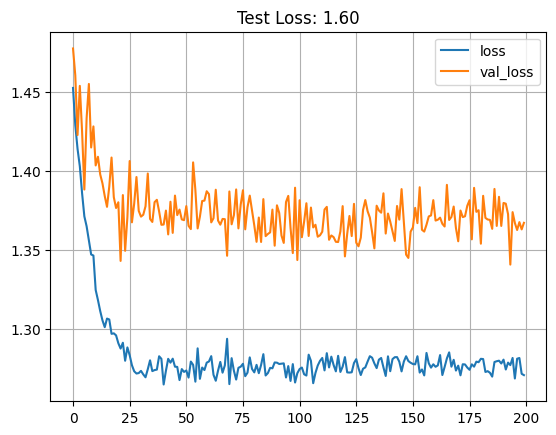

In [23]:
from tqdm import tqdm

history = {
    "loss":[],
    "val_loss":[]
}

model = classification_model.to(device_)

epochs = 200
lr_ = 0.001

optimizer = optim.Adam(model.parameters(),lr=lr_)
learning_rate = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.1, patience=5)
loss_fn = nn.CrossEntropyLoss()

l1_lambda = 0
l2_lambda = 0.005

train_loss, val_loss = [], []

for e in tqdm(range(epochs)):

  running_loss = 0.0
  val_running_loss = 0.0
  steps = 0

  for i in range(3):

    indices = torch.randperm(X_train.size()[0])[:train_batch_size]

    x_ = X_train[indices,::].to(torch.float)
    x_ = abs(torch.fft.fft2(x_))
    y_ = y_train[indices,::].to(torch.float)

    x_ = x_.to(device_)
    y_ = y_.to(device_)

    model =model.train()

    optimizer.zero_grad()

    y_est = model(x_)
    y_est = y_est.requires_grad_(True)

    loss = loss_fn(y_est,y_)
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
    loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
    running_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    steps += 1

    # if steps == 5:
    #   break

  running_loss /= steps
  history["loss"].append(running_loss)

  val_running_loss = 0.0
  steps = 0

  for i in range(5):

    indices = torch.randperm(X_val.size()[0])[:val_batch_size]

    x_val = X_val[indices,::].to(torch.float)
    x_val = abs(torch.fft.fft2(x_val))
    y_val_ = y_val[indices,::].to(torch.float)

    x_val = x_val.to(device_)
    y_val_ = y_val_.to(device_)

    model = model.eval()
    y_est = model(x_val)

    loss = loss_fn(y_est,y_val_)
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
    loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
    val_running_loss += loss.item()

    steps += 1

    # if steps == 5:
    #   break


  val_running_loss /= steps
  history["val_loss"].append(val_running_loss)

  learning_rate.step(val_running_loss)
  last_lr = learning_rate.get_last_lr()

  print("----------------------------------------------------------------------------------")
  print(f"Epoch: {e}/{epochs} | loss: {running_loss:.2f} |  validation loss: {val_running_loss:.2f} | learning rate: {last_lr}")

model = model.eval()

y_ = model(X_test)
y_test = y_test.requires_grad_(True)

loss = loss_fn(y_test,y_)
l1_norm = sum(p.abs().sum() for p in model.parameters())
l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
print("------------------------------------------------------------------------------------")
print(f"Test Loss: {loss.item():.2f}")
print("------------------------------------------------------------------------------------")

print("Loss")
print(" ")
import matplotlib.pyplot as plt

plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="val_loss")

plt.title(f"Test Loss: {loss.item():.2f}")

plt.grid()
plt.legend()



In [24]:
def checkpoint_model(model,name,test_performance):
  model_ = {
      "model":model,
      "model_weights":model.state_dict(),
      "performance":test_performance
  }
  joblib.dump(model_,name)

In [25]:
checkpoint_model(model=model,name="cnn_23_clf.sav",test_performance="1.6 Test CrossEntropy Loss")